In [2]:
import pandas as pd
import numpy as np
from itertools import groupby
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import cluster,mixture
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import scipy

In [3]:
d_ms = pd.read_csv('../example_data/clustering/sample1114.csv')

In [4]:
d_ms.head()

,Average Rt(min),Average Mz,S/N average,20181114_CEC_CAL-8-no4_MSpos_1,20181114_CEC_CAL-8-no4_MSpos_2,20181114_CEC_CAL-8-no4_MSpos_3,20181114_CEC_CAL-8-no4_MSpos_4,20181114_CEC_CAL-8-no4_MSpos_5,20181114_CEC_CAL-8-no4_MSpos_6,20181114_CEC_CAL-8-no4_MSpos_7,...,20181114_SR520-Creek_Mix6A_3,20181114_SR520-Creek_Mix6B_1,20181114_SR520-Creek_Mix6B_2,20181114_SR520-Creek_Mix6B_3,20181114_SwanCreek-Dec_1,20181114_SwanCreek-Dec_2,20181114_SwanCreek-Dec_3,20181114_SwanCreek-May_1,20181114_SwanCreek-May_2,20181114_SwanCreek-May_3
0,8.381,100.03931,60.33,0,0,0,0,0,0,0,...,68,82,100,0,0,0,0,0,0,0
1,2.332,100.07604,88.07,412,754,1985,1639,2049,1796,2702,...,674,1609,1571,782,976,729,587,6437,3174,2708
2,2.544,100.11243,111.09,4168,3547,2459,3768,3544,1695,2862,...,2282,1246,1662,2120,840,1336,1665,1200,1191,1217
3,5.359,100.11253,155.25,1239,1145,1007,550,1254,781,1714,...,203706,231624,152532,231635,260914,258902,234764,234498,193185,193974
4,0.628,101.00802,20.59,1295,1499,1508,2067,2103,2153,1500,...,18334,14693,11126,10754,14120,10229,12813,10449,9869,11369


In [5]:
d_ms = d_ms.rename(columns={'Average Rt(min)': 'Average RT (min)', 'Average Mz': 'Average m/z', 'S/N average': 'Average sn'})
d_ms.insert(3, "Average score", 1)

In [6]:
keys=['CEC','Blank','ISTD','Wash','Shutdown']

In [7]:
def data_prep(d_input, blank_keyword, svb_thres=10, empty_thres=0, cv_thres=5,rt_range=[0, 30], mz_range=[0, 1200], sn_thres=3, score_thres=0, area_thres=5000):
    drop_index = np.argwhere(np.asarray(d_input[d_input.columns[4:]].max(axis=1)) < area_thres).reshape(1,-1)
    d_thres = d_input.drop(drop_index[0])
    
    d_thres = d_thres[(d_thres['Average RT (min)'] > rt_range[0]) & (d_thres['Average RT (min)'] < rt_range[1])]
    d_thres = d_thres[(d_thres['Average m/z'] > mz_range[0]) & (d_thres['Average m/z'] < mz_range[1])]
    d_thres = d_thres[d_thres['Average sn'] >= sn_thres]
    d_thres = d_thres[d_thres['Average score'] >= score_thres]
    d_thres.reset_index(inplace=True)
    d_thres.drop(columns=['index'],inplace=True)
    
    col_blank = []
    for key in blank_keyword:
        col_app = [col for col in d_thres.columns if key in col]
        col_blank += col_app
    col_sample = [col for col in d_thres.columns if col not in col_blank]
    
    d_sample = d_thres[d_thres[col_sample[4:]].max(axis=1) / d_thres[col_blank].mean(axis=1) > svb_thres][col_sample]
    d_sample.reset_index(inplace=True)
    d_sample.drop(columns=['index'],inplace=True)
    
    trip_list = [list(i) for j, i in groupby(d_sample.columns[4:], lambda a: a.split('_')[1])]

    for triplicate in tqdm(trip_list):
        for index, row in d_sample[triplicate].iterrows():
            if (row == 0).sum() > empty_thres:
                d_sample.loc[index, triplicate] = 0
            elif row.std() / row.mean() > cv_thres:
                d_sample.loc[index, triplicate] = 0 #If delete or reduce all number to avg?
    d_sample = d_sample[(d_sample.iloc[:,4:]!=0).sum(1) > 3]
    
    
    return d_sample

In [8]:
d_sample = data_prep(d_ms,keys,rt_range = [1,30], mz_range = [200,800], area_thres=500)

100%|██████████| 10/10 [03:32<00:00, 21.26s/it]


In [79]:
def ms_cluster(d_input, select_keyword, normalization='linear', d_reduce=True, d_reduce_method='tsne', perplexity=50, cluster_method='dbscan',eps=0.8,min_samples=10):
    col_select = []
    for key in select_keyword:
        col_app = [col for col in d_input.columns if key in col]
        col_select += col_app
    d_clu = d_input[col_select]
    
    c_data = d_clu.values
    c_norm = []
    for row in c_data:
        if normalization == 'linear':
            c_norm.append(row/max(row))
        elif normalization == 'zscore':
            c_norm.append((row-np.mean(row))/np.std(row))
        elif normalization == 'log':
            row[row==0]=1
            c_norm.append(np.log10(row)/np.log10(max(row)))
    c_norm = np.asarray(c_norm)
    d_norm = pd.DataFrame(c_norm)
    d_norm['index']=d_sample.index
    d_norm.set_index('index',inplace=True)
    d_norm.dropna(how='all',inplace=True)
    
    if d_reduce == True:
        if d_reduce_method == 'tsne':
            model = TSNE(learning_rate=100,perplexity=50,n_iter=1000) #Tune perplexity and n_iter
            transformed = model.fit_transform(d_norm)
            X=transformed.copy()
    elif d_reduce == False:
        X=d_norm.copy()
    
    if cluster_method == 'dbscan':
        dbscan = cluster.DBSCAN(eps=eps, min_samples=min_samples).fit(X)
        labels = dbscan.labels_
        unique_labels = set(dbscan.labels_)

        for i,k in enumerate(unique_labels):
            indexlist = list(np.argwhere(labels==k).reshape(1,-1)[0])
            sns.clustermap(d_norm.iloc[indexlist].values,cmap='Reds',col_cluster=True,yticklabels=False,xticklabels=False,figsize=(5,5))
            plt.title(str(dbscan)+'label='+ str(k))
            plt.show()

        d_init = d_sample.copy()
        d_label = d_init.loc[d_norm.index]
        d_label.insert(4,"label", dbscan.labels_.tolist())
    
    return d_label, d_norm

/home/dmar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/dmar/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


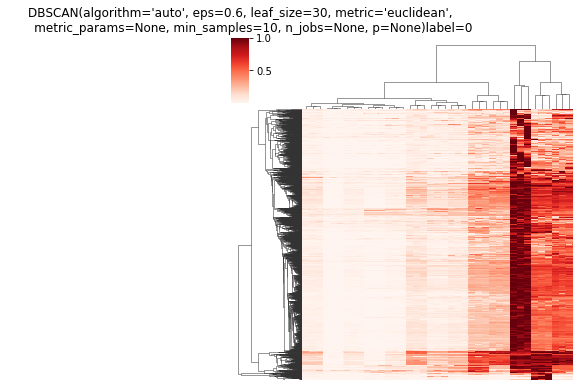

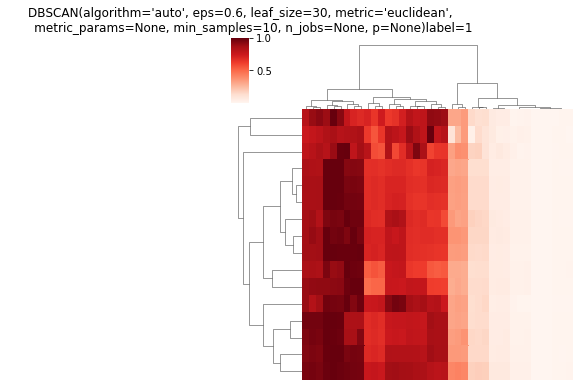

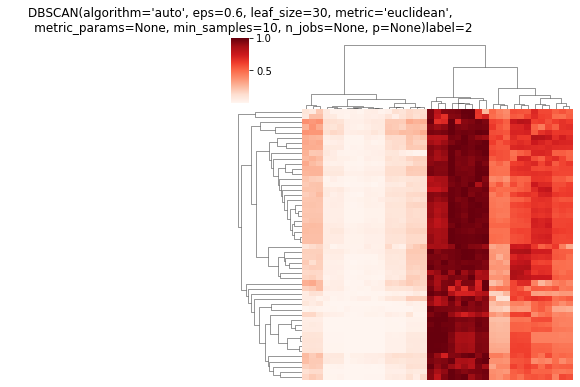

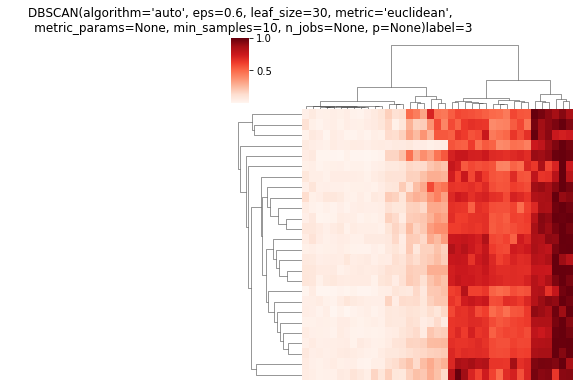

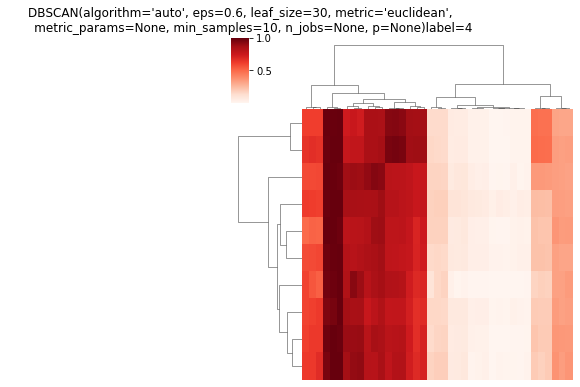

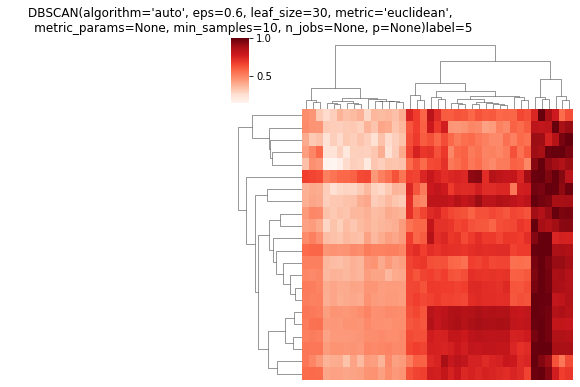

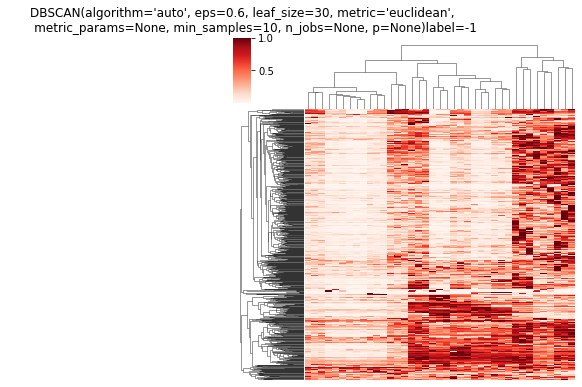

In [81]:
d_label, d_norm = ms_cluster(d_sample,['SR520-Cal'],'linear',d_reduce=False,eps=0.6)

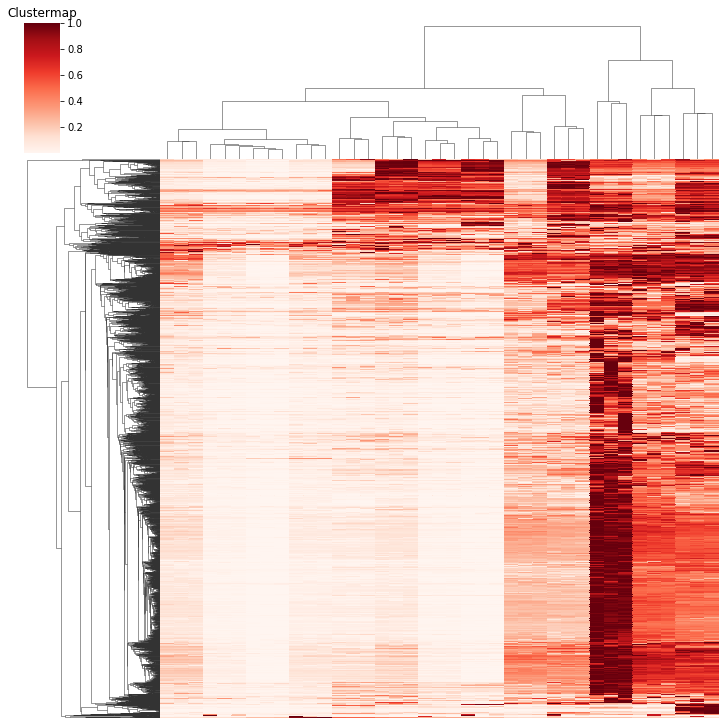

In [11]:
#no 0 is acceptable in the clustermap -- eye balling estimation?
sns.clustermap(d_norm.values,cmap='Reds',col_cluster=True,yticklabels=False,xticklabels=False)
plt.title('Clustermap')
plt.show()

In [12]:
# options: all_data/clusters seperately
# models: multiple linear/ random forest/ etc..
# def modeling:
#     select option
#     select model
#     if option all_data:
#         model.fit(data) --> training 1114data, test 0815data
#     elif option cluster:
#         for group in cluster:
#             model.fit(group)
#         all_model -- > final_model

In [13]:
# post filtering of dilution cluster
# source tracking:
#     1. samples from different sites
#     2. vann diagram--> 'source subtraction' --> unique features for different source
#     3. use cluster/noise distinguish method --> remove noises, get clusters
#     4. source proportioning prediction 

In [82]:
d_norm.insert(0,"RT", d_label['Average RT (min)'].tolist())
d_norm.insert(1,"MZ", d_label['Average m/z'].tolist())
d_norm = d_norm.dropna()
d_norm = d_norm.reset_index(drop=True)

# Trend Clustering Method 

In [133]:
def trend_calc(df, min_size, visual=True):
    """This function calculates clustering based on the pearson correlation.
    It takes in a dataframe and a user defined value for what qualifies as a cluster.
    User can choose whether or not to have a visual plot of the scatter with True/False."""
    cluster = [] # individual cluster holder
    cluster_sum = [] # total clusters
    drop_list = [] # rows that are dropped from the df
    noise = [] # list for containing noise features
    while len(df) > 0:
        for row in range(len(df)):
            feature_1 = df.iloc[0]
            feature_2 = df.iloc[row]
            corr, p_val = scipy.stats.pearsonr(df.iloc[0, 2:], df.iloc[row, 2:])
            if p_val < 0.05:
                drop_list.append(row)
                cluster += [feature_2]
            else:
                pass
        if len(cluster) <= min_size:
            noise += [cluster]
            cluster = []
        else:
            cluster_sum += [cluster]
            cluster = []
        df = df.drop(drop_list)
        df = df.reset_index(drop=True)
        drop_list = []
    append_list = []
    for i in range(len(cluster_sum)):
        for j in range(len(cluster_sum[i])):
            cluster_sum[i][j].loc['Score']= i
            listing = np.array(cluster_sum[i][j])
            append_list.append(listing)
    cluster_df = pd.DataFrame(append_list)
    append_list2 = []
    for k in range(len(noise)):
        for l in range(len(noise[k])):
            noise[k][l].loc['Score']= -1
            listing2 = np.array(noise[k][l])
            append_list2.append(listing2)
    noise_df = pd.DataFrame(append_list2)
    final_df = pd.concat([cluster_df, noise_df])
    final_df = final_df.reset_index(drop=True)
    if visual == True:
        rt=[]
        mz=[]
        for i in range(len(cluster_sum)):
            for j in range(len(cluster_sum[i])):
                rt.append(cluster_sum[i][j].loc['RT'])
                mz.append(cluster_sum[i][j].loc['MZ'])
            plt.scatter(rt,mz,label=i)
            rt=[]
            mz=[]
        rt2=[]
        mz2=[]
        for k in range(len(noise)):
            rt2.append(noise[k][0].loc['RT'])
            mz2.append(noise[k][0].loc['MZ'])
        plt.scatter(rt2,mz2,label='noise')
        plt.xlabel('RT')
        plt.ylabel('m/z')
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    else:
        pass
    return final_df

# Running Trend Cluster Algorithm

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,5.696,200.07405,0.043773,0.016115,0.036778,0.057383,0.069410,0.062652,0.114069,0.103672,...,0.153163,0.140391,0.133822,0.341320,0.320597,0.342348,0.684625,0.702205,0.666454,0.0
1,4.326,200.12823,0.053719,0.021857,0.032772,0.038357,0.029917,0.029841,0.073454,0.026961,...,0.056676,0.098317,0.055311,0.208687,0.262634,0.277087,0.436603,0.264504,0.567996,0.0
2,4.220,200.12869,0.022368,0.010567,0.021370,0.012156,0.019877,0.013788,0.038669,0.028210,...,0.075202,0.062766,0.042621,0.271490,0.164653,0.252118,0.360040,0.562095,0.351030,0.0
3,5.920,200.16484,0.002092,0.001970,0.002784,0.020899,0.020606,0.021477,0.067364,0.067762,...,0.106602,0.106790,0.111964,0.256398,0.251906,0.259326,0.571807,0.550691,0.554270,0.0
4,5.785,201.03792,0.013213,0.108866,0.068652,0.027384,0.032363,0.063386,0.136442,0.051609,...,0.027959,0.044332,0.084833,0.220988,0.152815,0.260149,0.587610,0.470031,0.176944,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2546,17.210,697.65814,0.039682,0.132852,0.109342,0.024132,0.015425,0.068168,0.216694,0.157233,...,0.008956,0.044906,0.074387,0.022142,0.017913,0.076129,0.203881,0.147406,0.107600,-1.0
2547,19.466,735.64166,0.000549,0.089903,0.001432,0.703338,0.110908,0.003229,0.008822,0.004916,...,0.034404,0.012945,0.011697,0.005810,0.015346,0.015897,0.009215,0.160814,0.001594,-1.0
2548,17.270,781.58441,0.334745,0.393467,0.820890,0.420675,0.357789,0.786791,0.351759,0.401292,...,0.604810,0.794688,0.892175,0.442570,0.168126,0.534099,0.541206,0.410050,0.680043,-1.0
2549,20.941,731.60840,1.000000,0.167016,0.010311,0.019754,0.011468,0.008977,0.010166,0.006437,...,0.025331,0.016796,0.035650,0.019416,0.056425,0.052816,0.602920,0.098167,0.039886,-1.0


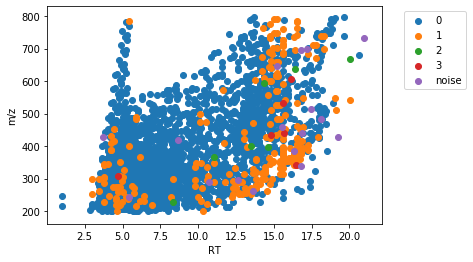

In [134]:
trend_calc(d_norm, 5, visual=True)     